Interface Cérebro-Máquina - Processamento de Sinais EMG
Projeto de Transição: Biologia para Engenharia de Software Biomédico

In [12]:
import os
from dotenv import load_dotenv

# 1. Carrega as variáveis do .env
load_dotenv()

# 2. Pega o caminho configurado
raw_path = os.getenv("DATASET_RAW_PATH")

# 3. Verifica se os arquivos estão lá
if raw_path and os.path.exists(raw_path):
    print(f"✅ J.A.R.V.I.S.: Conexão estabelecida!")
    print(f"Arquivos detectados: {os.listdir(raw_path)}")
else:
    print(f"❌ Erro: O caminho '{raw_path}' não foi encontrado. Verifique seu .env!")

✅ J.A.R.V.I.S.: Conexão estabelecida!
Arquivos detectados: ['DB2_s1']


In [13]:
from scipy.io import loadmat
import pandas as pd

# 1. Definir o caminho do primeiro arquivo do Sujeito 1
# (Ajuste o nome do arquivo se for diferente no seu computador)
arquivo_path = os.path.join(raw_path, 'DB2_s1', 'S1_E1_A1.mat')

# 2. Carregar o arquivo
data = loadmat(arquivo_path)

# 3. No Ninapro, 'emg' contém os dados dos sensores e 'stimulus' o gesto
emg_raw = data['emg']
gesto = data['stimulus']

# 4. Transformar em um DataFrame (Tabela Estilo Excel)
df_emg = pd.DataFrame(emg_raw)

print(f"📊 Dados carregados! Temos {df_emg.shape[0]} amostras de {df_emg.shape[1]} sensores.")
print(f"Gesto atual no arquivo: {gesto.max()} tipos detectados.")

📊 Dados carregados! Temos 1808331 amostras de 12 sensores.
Gesto atual no arquivo: 17 tipos detectados.


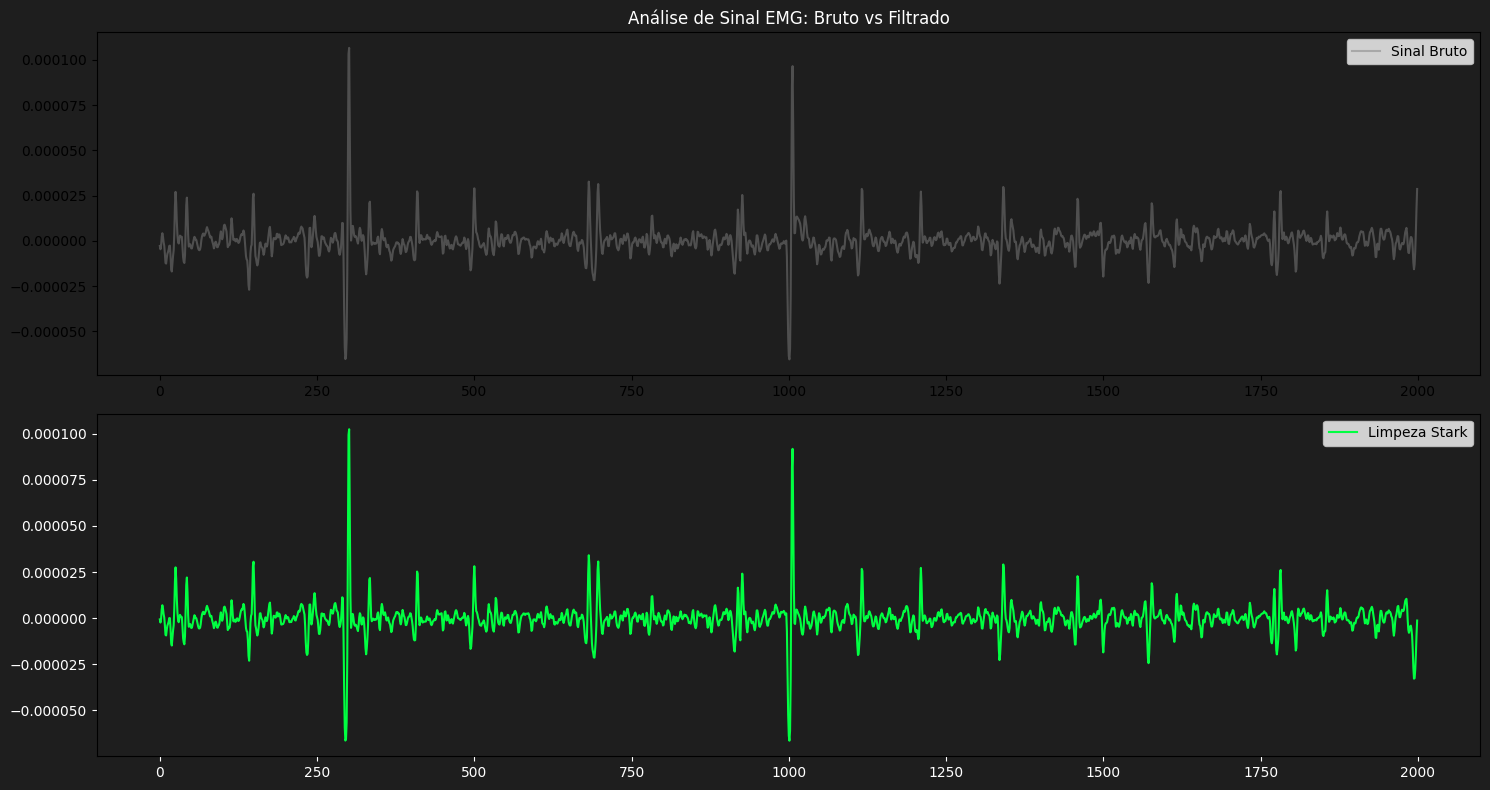

In [14]:
# --- Célula 3: Processamento de Sinais (Bruto vs Filtrado) ---
from scipy import signal
import matplotlib.pyplot as plt

# 1. Seleção do trecho de sinal (Independência de células deletadas)
fs = 1000       # Frequência de amostragem
sinal_bruto = df_emg.iloc[:2000, 0] 

# 2. Configuração e Aplicação do Filtro Butterworth
nyq = 0.5 * fs
low, high = 20.0 / nyq, 450.0 / nyq
b, a = signal.butter(4, [low, high], btype='band')
sinal_filtrado = signal.filtfilt(b, a, sinal_bruto)

# 3. Geração do Gráfico Comparativo
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(sinal_bruto, color='gray', alpha=0.5, label='Sinal Bruto')
plt.title('Análise de Sinal EMG: Bruto vs Filtrado', color='white')
plt.gca().set_facecolor('#1e1e1e')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sinal_filtrado, color='#00ff41', label='Limpeza Stark')
plt.gca().set_facecolor('#1e1e1e')
plt.legend()

plt.gcf().set_facecolor('#1e1e1e')
plt.tick_params(colors='white')
plt.tight_layout()
plt.show()

In [15]:
# --- Célula 4: Expansão Multicanal (12 Sensores) ---
import numpy as np
from scipy import signal

# 1. Filtro Butterworth aplicado em massa
# O filtfilt consegue processar todas as colunas de uma vez se passarmos o DataFrame inteiro
print("⚔️ J.A.R.V.I.S.: Aplicando filtros nos 12 canais simultaneamente...")
emg_filtrado_total = signal.filtfilt(b, a, df_emg.values, axis=0)

# 2. Função de Extração Otimizada
def extrair_features_multicanal(sinal_total, janela_tamanho=200):
    num_amostras = sinal_total.shape[0]
    num_sensores = sinal_total.shape[1]
    features_lista = []
    
    # Percorre o sinal em saltos (janelas)
    for i in range(0, num_amostras - janela_tamanho, janela_tamanho):
        janela = sinal_total[i:i+janela_tamanho, :] # Pega os 12 sensores de uma vez
        
        # MAV (Mean Absolute Value) por coluna
        mav = np.mean(np.abs(janela), axis=0)
        
        # RMS (Root Mean Square) por coluna
        rms = np.sqrt(np.mean(janela**2, axis=0))
        
        # ZC (Zero Crossing) por coluna
        # Comparamos sinais adjacentes e somamos as trocas de sinal
        zc = np.sum((janela[:-1, :] * janela[1:, :]) < 0, axis=0)
        
        # Concatena tudo: [MAV1..12, RMS1..12, ZC1..12] -> 36 features
        features_lista.append(np.concatenate([mav, rms, zc]))
        
    return np.array(features_lista)

# 3. Execução
features_multicanal = extrair_features_multicanal(emg_filtrado_total)

# 4. Sincronização dos Labels (Gesto)
labels_multicanal = []
for i in range(0, len(gesto) - 200, 200):
    labels_multicanal.append(gesto[i + 100][0])
labels_multicanal = np.array(labels_multicanal)

print(f"🔥 Expansão Concluída! Matriz de Treinamento: {features_multicanal.shape}")
print(f"Agora cada janela possui {features_multicanal.shape[1]} características biomecânicas.")

⚔️ J.A.R.V.I.S.: Aplicando filtros nos 12 canais simultaneamente...
🔥 Expansão Concluída! Matriz de Treinamento: (9041, 36)
Agora cada janela possui 36 características biomecânicas.


In [16]:
# --- Célula 5: Treinamento da IA (Random Forest Multicanal) ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Divisão dos dados usando as novas variáveis multicanal
# X são as características (36 colunas) e y são os rótulos (gestos)
X_train, X_test, y_train, y_test = train_test_split(
    features_multicanal, labels_multicanal, test_size=0.2, random_state=42
)

# 2. Inicialização do Modelo
# Aumentamos um pouco o n_estimators para lidar com a complexidade maior
modelo_ia = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 3. TREINAMENTO
print("🧠 J.A.R.V.I.S.: Analisando padrões dos 12 sensores...")
modelo_ia.fit(X_train, y_train)

# 4. AVALIAÇÃO
previsoes = modelo_ia.predict(X_test)
acuracia = accuracy_score(y_test, previsoes)

print(f"✅ Treinamento concluído!")
print(f"📊 Nova Acurácia com Expansão Territorial: {acuracia:.2%}")

🧠 J.A.R.V.I.S.: Analisando padrões dos 12 sensores...
✅ Treinamento concluído!
📊 Nova Acurácia com Expansão Territorial: 73.69%


In [17]:
# --- Célula 6: Simulação de Prótese em Tempo Real (Multicanal) ---
import random

# 1. Escolher um índice aleatório do conjunto de teste
indice_aleatorio = random.randint(0, len(X_test)-1)

# 2. Pegar os dados (que já possuem as 36 características)
exemplo_multicanal = X_test[indice_aleatorio].reshape(1, -1)
gesto_real = y_test[indice_aleatorio]

# 3. A IA faz a predição baseada nos 12 sensores
predicao_ia = modelo_ia.predict(exemplo_multicanal)[0]

# 4. Painel de Controle J.A.R.V.I.S.
print(f"📡 --- MONITORAMENTO DE TELEMETRIA BIOELÉTRICA ---")
print(f"🧬 Vetor de Entrada (12 Canais x 3 Features): {exemplo_multicanal.shape}")
print(f"🤖 J.A.R.V.I.S. previu o gesto: {predicao_ia}")
print(f"👤 Movimento Real do Usuário: {gesto_real}")

if predicao_ia == gesto_real:
    print("\n✅ SUCESSO: Sincronização neural perfeita. A prótese executou o comando.")
else:
    print("\n⚠️ DIVERGÊNCIA: Ruído detectado ou gesto complexo. Revisando padrões...")

📡 --- MONITORAMENTO DE TELEMETRIA BIOELÉTRICA ---
🧬 Vetor de Entrada (12 Canais x 3 Features): (1, 36)
🤖 J.A.R.V.I.S. previu o gesto: 2
👤 Movimento Real do Usuário: 4

⚠️ DIVERGÊNCIA: Ruído detectado ou gesto complexo. Revisando padrões...


Este projeto validou o pipeline de processamento para um único sensor. Próxima iteração: Expansão para os 12 sensores do NinaPro DB2 para otimização da acurácia.